In [1]:
import gym
from stable_baselines3 import PPO, DQN
from datetime import datetime
from gym.wrappers import TimeLimit


In [2]:
side_length = 4
env = gym.make("gym_xymodel:isingmodel-v0", side_len=side_length)
env = TimeLimit(env, max_episode_steps=100)
from stable_baselines3.common.env_checker import check_env
check_env(env)
# env = gym.make('CartPole-v1')

/home/michelangelo/Documents/spin-lattice-RL/gym-xymodel/gym_xymodel/envs/isingmodel_env.py:38: RuntimeWarning: overflow encountered in ubyte_scalars
  lattice[i, j] * (lattice[i - 1, j] + lattice[i, j - 1])
/home/michelangelo/miniconda3/envs/spinlatrl/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:34: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/home/michelangelo/miniconda3/envs/spinlatrl/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:47: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom feature extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  warnings.warn(


IndexError: index 13 is out of bounds for axis 0 with size 1

In [3]:
import gym
import torch as th
import torch.nn as nn

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)   

In [4]:
date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder_path = f"../results/ising/{date}_{side_length}x{side_length}"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, tensorboard_log=folder_path, verbose=1)
model.learn(total_timesteps=1000)
# model.save(f"{folder_path}/model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 16, 8, 8], but got 2-dimensional input of size [1, 16] instead

In [ ]:
model = PPO.load("results/2022-02-20_00-02-28_isingmodelSB_3x3")

reward=0
[[ 1  1 -1 -1 -1  1 -1]
 [-1 -1 -1 -1  1  1  1]
 [-1 -1 -1  1  1 -1  1]
 [-1  1 -1 -1  1 -1 -1]
 [-1 -1  1 -1 -1  1  1]
 [ 1  1  1 -1 -1  1  1]
 [-1  1 -1  1 -1  1 -1]]


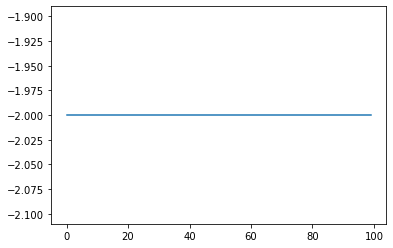

In [13]:
energies = []
obs = env.reset()
for i in range(200):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    energies.append(info["energy"])
    if done:
      print(f"{reward=}")
      env.render()
      break
      # env.reset()
    # if i % 100 == 0:
    #   print(f"{i=}, {reward=}")
    #   env.render()

import matplotlib.pyplot as plt
plt.plot(range(len(energies)),energies)

In [ ]:
obs = env.reset()
env.render()
for i in range(10):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print(f"{i=}, {action=} {reward=}, {env.compute_energy()=}")
    env.render()

[[ 1  1 -1 -1  1]
 [ 1 -1 -1 -1  1]
 [-1 -1 -1  1  1]
 [ 1  1  1  1 -1]
 [ 1  1  1 -1 -1]]
i=0, action=2 reward=-40, env.compute_energy()=-10
[[ 1  1  1 -1  1]
 [ 1 -1 -1 -1  1]
 [-1 -1 -1  1  1]
 [ 1  1  1  1 -1]
 [ 1  1  1 -1 -1]]
i=1, action=23 reward=0, env.compute_energy()=-10
[[ 1  1  1 -1  1]
 [ 1 -1 -1 -1  1]
 [-1 -1 -1  1  1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]]
i=2, action=19 reward=4, env.compute_energy()=-14
[[ 1  1  1 -1  1]
 [ 1 -1 -1 -1  1]
 [-1 -1 -1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1 -1]]
i=3, action=24 reward=8, env.compute_energy()=-22
[[ 1  1  1 -1  1]
 [ 1 -1 -1 -1  1]
 [-1 -1 -1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]]
i=4, action=10 reward=4, env.compute_energy()=-26
[[ 1  1  1 -1  1]
 [ 1 -1 -1 -1  1]
 [ 1 -1 -1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]]
i=5, action=8 reward=0, env.compute_energy()=-26
[[ 1  1  1 -1  1]
 [ 1 -1 -1  1  1]
 [ 1 -1 -1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]]
i=6, action=3 reward=8, env.compute_energy()=-34
[[ 1  1  1  1 